# Circuit Detector

In [39]:
import os, object_detection, cv2
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_utils
from object_detection.builders import model_builder
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [40]:
modelName = "640x640_model"

filePaths = {
    "IMAGES": os.path.join("TF", "workspace", "images"),
    'MODELS': os.path.join('TF', 'workspace','models'),
    'CHECKPOINTS': os.path.join('TF', 'workspace','models', modelName),
    "ANNOTATIONS": os.path.join("TF", "workspace", "annotations")
}

In [41]:
labelMap = "label_map.pbtxt"

files = {
    'PIPELINE_CONFIG':os.path.join('TF', 'workspace','models', modelName, 'pipeline.config'),
    'LABELMAP': os.path.join(filePaths['ANNOTATIONS'], labelMap)
}

## Load config and model

In [42]:
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

In [43]:
# Restore chosen ckpt

checkpointNum = 11

checkpoint = "ckpt-" + str(checkpointNum)

ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(filePaths['CHECKPOINTS'], checkpoint)).expect_partial()

## Detect components in still image

In [44]:
cat_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])


def detect(image):
    image, shapes = detection_model.preprocess(image)
    predictionDict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(predictionDict, shapes)
    return detections

(1, 1080, 1440, 3)


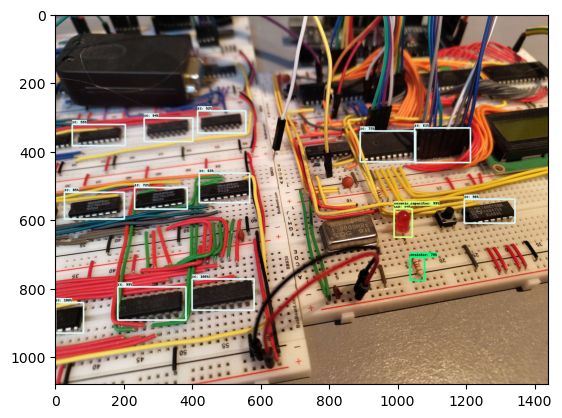

In [45]:
IMAGE_PATH = os.path.join(filePaths['IMAGES'], 'test', 'phone.jpg')

img = cv2.imread(IMAGE_PATH)
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
print(input_tensor.shape)

detections = detect(input_tensor)

num_detections = int(detections.pop('num_detections'))
#num_detections = len(detections)
detections = {key: value[0, :num_detections].numpy() for key, value in detections.items()}

detections["num_detections"] = num_detections

detections["detection_classes"] = detections["detection_classes"].astype(np.int64)

labelIdOffset = 1
image_np_detections = image_np.copy()

vis_utils.visualize_boxes_and_labels_on_image_array(
            image_np_detections,
            detections['detection_boxes'],
            detections['detection_classes']+labelIdOffset,
            detections['detection_scores'],
            cat_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=20,
            min_score_thresh=0.5,
            line_thickness= 5,
            agnostic_mode=False)

plt.imshow(cv2.cvtColor(image_np_detections, cv2.COLOR_BGR2RGB))
plt.show()